### Transfer Learning(전이학습)을 이용한 사과, 토마토 분류 

1.   전이학습은 높은 정확도를 비교적 짧은 시간 내에 달성할 수 있기 때문에 컴퓨터 비전 분야에서 유명한 방법론 중 하나입니다.

2.   전이학습을 위해서는 VGG, Inception, MobileNet과 같은 대량의 데이터셋으로 이미 학습이 되어있는 모델을 사용합니다. 이를 '사전에 학습된 모델' 혹은 'pre-trained model'이라고 부릅니다.

3.   tensorflow 같은 딥러닝 프레임워크에서 API 저장되어 있어 간편하게 불러와서 사용하실 수 있습니다

4.   사용법은 사전 학습된 CNN구조를 그대로 두고 뒷단에 분류를 위해 새로운 완전연결레이어(FC: Fully Connected Layer)를 붙여서 학습시키면 됩니다.






In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#압축해제된 데이터파일이 있는지 확인 후 없으면 압축을 해제.
if not os.path.isdir('/content/drive/MyDrive/pop/apple-tomato-classification/apple-tomato-data'):
  zip = zipfile.ZipFile('/content/drive/MyDrive/pop/apple-tomato-classification/apple_tomato.zip', 'r')
  zip.extractall('/content/drive/MyDrive/pop/apple-tomato-classification/apple-tomato-data')
  zip.close()

In [4]:
# directory 경로를 지정
main_dir = '/content/drive/MyDrive/pop/apple-tomato-classification/apple-tomato-data'
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')

In [5]:
labels = {
    'tomatoes': 0,
    'apples': 1
}

In [6]:
from skimage.io import imread
from skimage.transform import resize
IMAGE_SIZE = (224,224,3)
train_images = []
train_labels = []

# 1. 분류할 학습 이미지 폴더를 순차적으로 불러옵니다.
# 2. 수치화된 이미지 데이터의 사이즈를 조절 후 리스트에 추가.
# 3. 두개의 폴더에 라벨을 지정  
for image_label in os.listdir(train_dir):
  image_dir = os.path.join(train_dir, image_label)
  for image_title in os.listdir(image_dir):
      image_path = os.path.join(image_dir, image_title)
      image = imread(image_path)
      image = resize(image, IMAGE_SIZE)
      train_images.append(image)
      train_labels.append(labels[image_label])

In [7]:
test_images = []
test_labels = []

for image_label in os.listdir(test_dir):
  image_dir = os.path.join(test_dir, image_label)
  for image_title in os.listdir(image_dir):
      image_path = os.path.join(image_dir, image_title)
      image = imread(image_path)
      image = resize(image, IMAGE_SIZE)
      test_images.append(image)
      test_labels.append(labels[image_label])

In [8]:
# 데이터 처리에 용이한 numpy배열로 변환환
X_train = np.array(train_images)
X_test = np.array(test_images)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [56]:
# 사전 학습된 모델을 호출
resnet = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
vgg = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
xception = Xception(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
resnet101 = ResNet101(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
inception = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [57]:
model_dict = {
    'resnet50': resnet,
    'vgg16': vgg,
    'xception': xception,
    'resnet101': resnet101,
    'inception': inception,
    'mobilenet': mobilenet,
}
model_dict

{'resnet50': <keras.engine.functional.Functional at 0x7ff04c1fcc70>,
 'vgg16': <keras.engine.functional.Functional at 0x7ff0201ac550>,
 'xception': <keras.engine.functional.Functional at 0x7ff0187f6b20>,
 'resnet101': <keras.engine.functional.Functional at 0x7ff01839ea90>,
 'inception': <keras.engine.functional.Functional at 0x7fefe48331c0>,
 'mobilenet': <keras.engine.functional.Functional at 0x7fefe46a2b80>}

In [58]:
# 사전학습된 모델의 가중치가 갱신되지 않게 함. 
for key, netModel in model_dict.items():
  for layer in netModel.layers:
      layer.trainable = False

In [59]:
history_list = []
model_keys = list(model_dict.keys())

Epoch 1/20
10/10 [==============================] - 8s 267ms/step - loss: 15.5592 - accuracy: 0.4218 - val_loss: 0.6846 - val_accuracy: 0.5670
Epoch 2/20
10/10 [==============================] - 2s 166ms/step - loss: 1.6895 - accuracy: 0.5578 - val_loss: 1.1457 - val_accuracy: 0.4433
Epoch 3/20
10/10 [==============================] - 1s 136ms/step - loss: 1.0306 - accuracy: 0.5068 - val_loss: 1.0739 - val_accuracy: 0.5567
Epoch 4/20
10/10 [==============================] - 1s 133ms/step - loss: 0.8341 - accuracy: 0.5306 - val_loss: 0.6457 - val_accuracy: 0.6289
Epoch 5/20
10/10 [==============================] - 1s 127ms/step - loss: 0.6579 - accuracy: 0.6156 - val_loss: 0.6098 - val_accuracy: 0.7320
Epoch 6/20
10/10 [==============================] - 1s 128ms/step - loss: 0.6136 - accuracy: 0.6735 - val_loss: 0.5979 - val_accuracy: 0.7216
Epoch 7/20
10/10 [==============================] - 1s 128ms/step - loss: 0.6099 - accuracy: 0.6701 - val_loss: 0.6126 - val_accuracy: 0.6392
Epoch

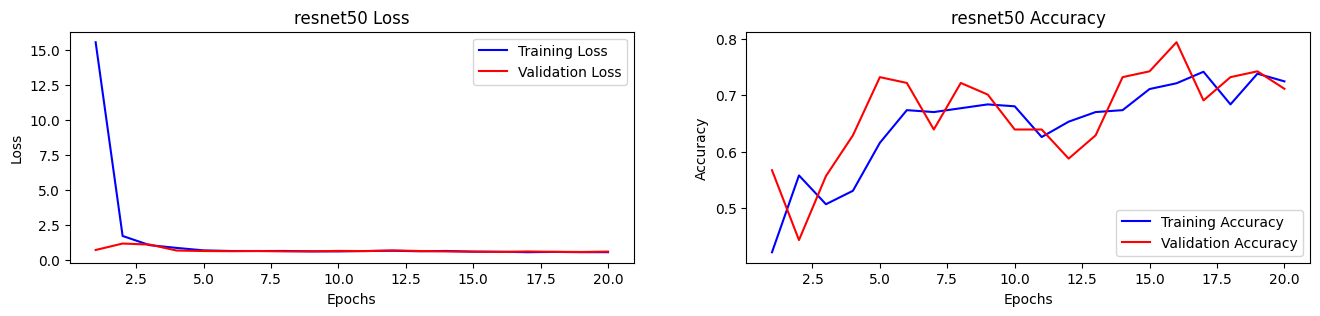

Epoch 1/20
10/10 [==============================] - 3s 228ms/step - loss: 2.7874 - accuracy: 0.5782 - val_loss: 0.7513 - val_accuracy: 0.7216
Epoch 2/20
10/10 [==============================] - 2s 160ms/step - loss: 0.6129 - accuracy: 0.7823 - val_loss: 0.4359 - val_accuracy: 0.8144
Epoch 3/20
10/10 [==============================] - 2s 161ms/step - loss: 0.2632 - accuracy: 0.8980 - val_loss: 0.4213 - val_accuracy: 0.8557
Epoch 4/20
10/10 [==============================] - 2s 165ms/step - loss: 0.1195 - accuracy: 0.9592 - val_loss: 0.3634 - val_accuracy: 0.8454
Epoch 5/20
10/10 [==============================] - 2s 199ms/step - loss: 0.0510 - accuracy: 0.9932 - val_loss: 0.3719 - val_accuracy: 0.8454
Epoch 6/20
10/10 [==============================] - 2s 195ms/step - loss: 0.0290 - accuracy: 0.9932 - val_loss: 0.3758 - val_accuracy: 0.8454
Epoch 7/20
10/10 [==============================] - 2s 190ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.3970 - val_accuracy: 0.8454
Epoch 

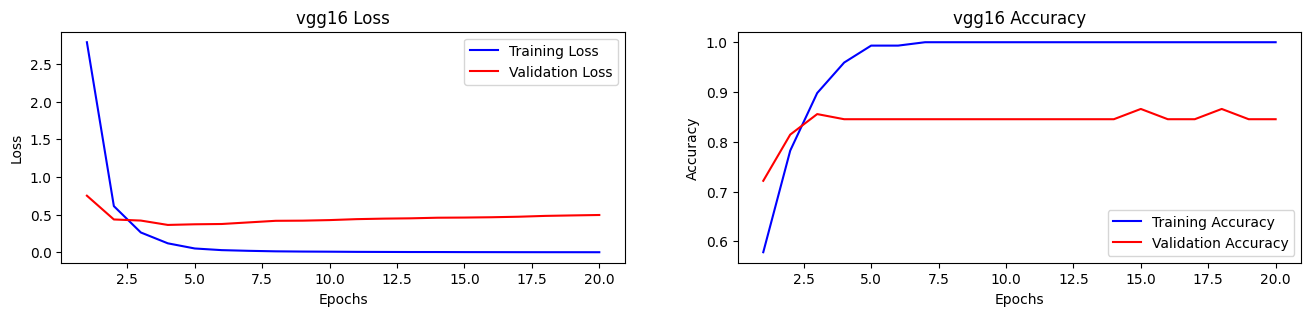

Epoch 1/20
10/10 [==============================] - 6s 344ms/step - loss: 7.2523 - accuracy: 0.7279 - val_loss: 3.1003 - val_accuracy: 0.7938
Epoch 2/20
10/10 [==============================] - 2s 165ms/step - loss: 1.0479 - accuracy: 0.9082 - val_loss: 1.1721 - val_accuracy: 0.8660
Epoch 3/20
10/10 [==============================] - 2s 193ms/step - loss: 0.2506 - accuracy: 0.9592 - val_loss: 1.8628 - val_accuracy: 0.7938
Epoch 4/20
10/10 [==============================] - 2s 167ms/step - loss: 0.1625 - accuracy: 0.9728 - val_loss: 1.2837 - val_accuracy: 0.8866
Epoch 5/20
10/10 [==============================] - 2s 165ms/step - loss: 0.1214 - accuracy: 0.9796 - val_loss: 1.9075 - val_accuracy: 0.8454
Epoch 6/20
10/10 [==============================] - 2s 192ms/step - loss: 0.0264 - accuracy: 0.9966 - val_loss: 1.2794 - val_accuracy: 0.8660
Epoch 7/20
10/10 [==============================] - 2s 168ms/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 1.4281 - val_accuracy: 0.8660
Epoch 

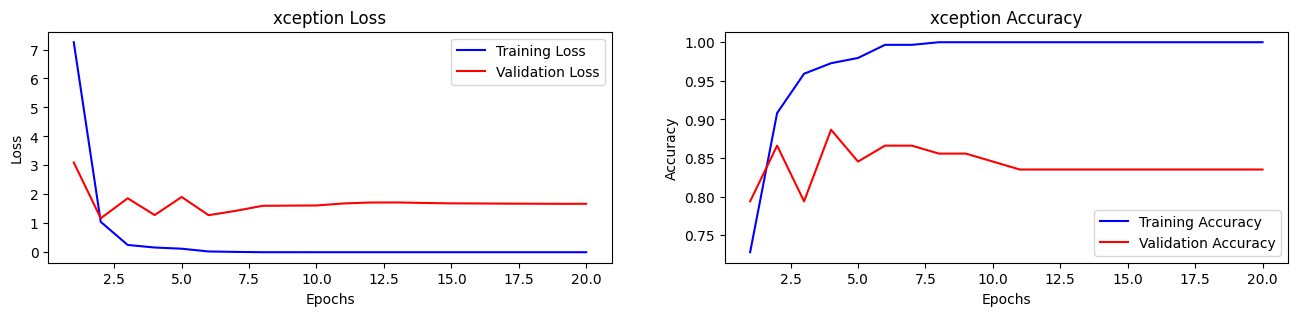

Epoch 1/20
10/10 [==============================] - 12s 651ms/step - loss: 10.2864 - accuracy: 0.4592 - val_loss: 0.6388 - val_accuracy: 0.6392
Epoch 2/20
10/10 [==============================] - 2s 206ms/step - loss: 1.4655 - accuracy: 0.5510 - val_loss: 0.8778 - val_accuracy: 0.6392
Epoch 3/20
10/10 [==============================] - 2s 222ms/step - loss: 0.7103 - accuracy: 0.6871 - val_loss: 0.6958 - val_accuracy: 0.6289
Epoch 4/20
10/10 [==============================] - 2s 208ms/step - loss: 0.6352 - accuracy: 0.6905 - val_loss: 0.5910 - val_accuracy: 0.6804
Epoch 5/20
10/10 [==============================] - 2s 208ms/step - loss: 0.5336 - accuracy: 0.7449 - val_loss: 0.6221 - val_accuracy: 0.7113
Epoch 6/20
10/10 [==============================] - 2s 226ms/step - loss: 0.4853 - accuracy: 0.7585 - val_loss: 0.6552 - val_accuracy: 0.6598
Epoch 7/20
10/10 [==============================] - 2s 216ms/step - loss: 0.5094 - accuracy: 0.7483 - val_loss: 0.5354 - val_accuracy: 0.7216
Epoc

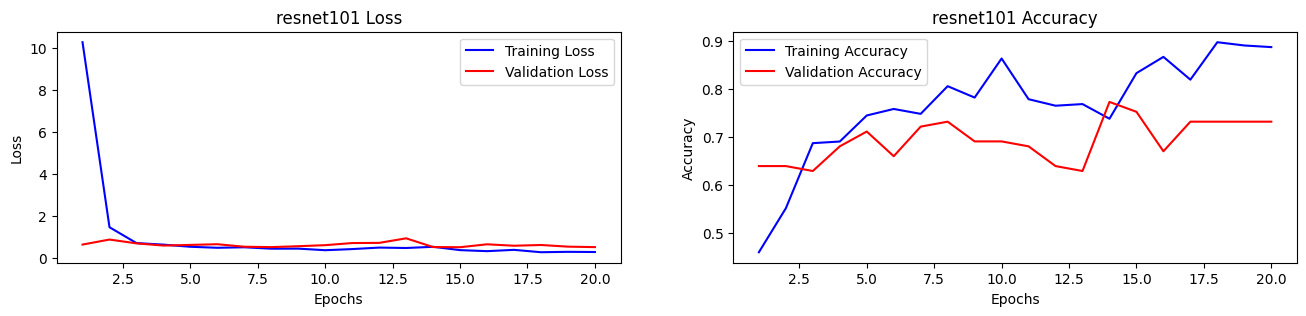

Epoch 1/20
10/10 [==============================] - 10s 384ms/step - loss: 23.2619 - accuracy: 0.5340 - val_loss: 2.4764 - val_accuracy: 0.7938
Epoch 2/20
10/10 [==============================] - 1s 98ms/step - loss: 4.4066 - accuracy: 0.7313 - val_loss: 4.2463 - val_accuracy: 0.6701
Epoch 3/20
10/10 [==============================] - 1s 107ms/step - loss: 2.0990 - accuracy: 0.8299 - val_loss: 2.6561 - val_accuracy: 0.7938
Epoch 4/20
10/10 [==============================] - 1s 110ms/step - loss: 1.1020 - accuracy: 0.8707 - val_loss: 1.5425 - val_accuracy: 0.7835
Epoch 5/20
10/10 [==============================] - 1s 96ms/step - loss: 0.7168 - accuracy: 0.8912 - val_loss: 0.9685 - val_accuracy: 0.8247
Epoch 6/20
10/10 [==============================] - 1s 95ms/step - loss: 0.3373 - accuracy: 0.9524 - val_loss: 0.6631 - val_accuracy: 0.8454
Epoch 7/20
10/10 [==============================] - 1s 94ms/step - loss: 0.0817 - accuracy: 0.9796 - val_loss: 0.6039 - val_accuracy: 0.8557
Epoch 8/

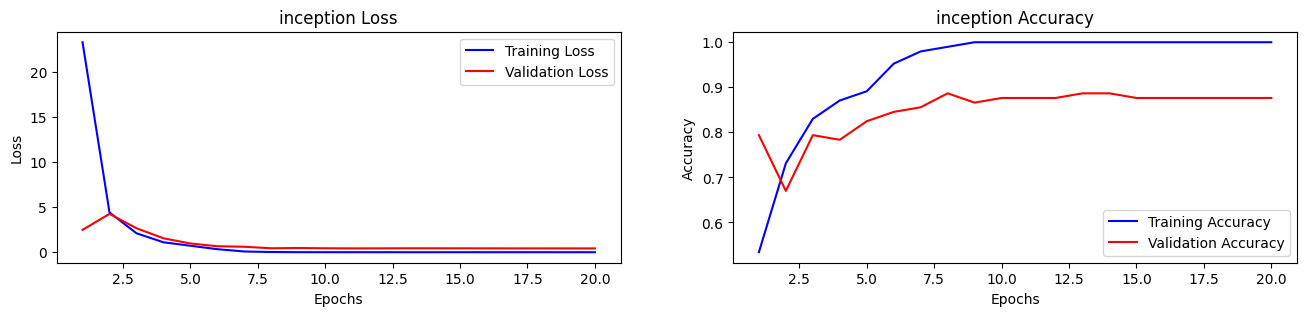

Epoch 1/20
10/10 [==============================] - 5s 179ms/step - loss: 7.9570 - accuracy: 0.7075 - val_loss: 5.2248 - val_accuracy: 0.7732
Epoch 2/20
10/10 [==============================] - 1s 79ms/step - loss: 0.7930 - accuracy: 0.9558 - val_loss: 1.9846 - val_accuracy: 0.8454
Epoch 3/20
10/10 [==============================] - 1s 67ms/step - loss: 0.0997 - accuracy: 0.9762 - val_loss: 2.9330 - val_accuracy: 0.8351
Epoch 4/20
10/10 [==============================] - 1s 66ms/step - loss: 0.0334 - accuracy: 0.9898 - val_loss: 1.9122 - val_accuracy: 0.8557
Epoch 5/20
10/10 [==============================] - 1s 84ms/step - loss: 0.0330 - accuracy: 0.9932 - val_loss: 1.8723 - val_accuracy: 0.8866
Epoch 6/20
10/10 [==============================] - 1s 102ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.2431 - val_accuracy: 0.8866
Epoch 7/20
10/10 [==============================] - 1s 83ms/step - loss: 2.3278e-04 - accuracy: 1.0000 - val_loss: 2.2937 - val_accuracy: 0.8763
Epoch 8

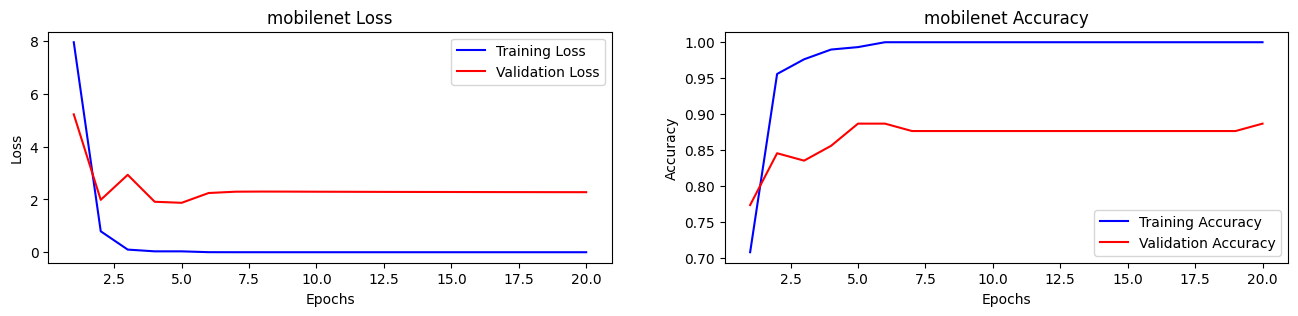

In [60]:
# 사전 학습된 CNN 모델을 1차원 레이어로 바꿔서
# 은닉층과 출력층이 있는 Dense 레이어로 학습을 함.
# 은닉층 활성화 함수 : ReLU, 출력층 활성화 함수 : sigmoid
# 최적화 함수 : Adam

for key, netModel in model_dict.items():
  model = keras.Sequential()
  model.add(netModel)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(2, activation='sigmoid'))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  History = model.fit(X_train, y_train, validation_data = (X_test, y_test), validation_split=0.2, epochs=20)
  history_dict = History.history

  # 모델 평가
  print("\n=============test results==========")
  model.evaluate(X_test, y_test)[1]

  # 모델 저장
  model.save(f'/content/drive/MyDrive/pop/model/apple-tomato-classification-{key}-TransferModel.h5')

  # 학습, 검증데이터 각각의 loss와 accuracy를 시각화
  plt.figure(figsize=(16, 3))
  plt.subplot(1,2,1)
  plt.plot(epoch_runs, history_dict['loss'], 'b', label='Training Loss')
  plt.plot(epoch_runs, history_dict['val_loss'], 'r', label='Validation Loss')
  plt.title(f'{key} Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epoch_runs, history_dict['accuracy'], 'b', label='Training Accuracy')
  plt.plot(epoch_runs, history_dict['val_accuracy'], 'r', label='Validation Accuracy')
  plt.title(f'{key} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()



In [61]:
# 학습, 검증데이터 각각의 loss와 accuracy 수치
for i in range(len(history_list)):
  print('{0}의 loss : {1}'.format(model_keys[i], history_list[i]['loss'][-1])) 
  print('{0}의 val_loss : {1}'.format(model_keys[i], history_list[i]['val_loss'][-1]))
  print('{0}의 accuracy : {1}'.format(model_keys[i], history_list[i]['accuracy'][-1]))
  print('{0}의 val_accuracy : {1}\n'.format(model_keys[i], history_list[i]['val_accuracy'][-1]))
  val_acc_list.append(history_list[i]['val_accuracy'][-1])

In [62]:
# 검증 데이터의 accuracy가 가장 높은 모델을 best model로 지정
# best model을 제외한 나머지 모델은 directory에서 제거

best_model = model_keys[tf.argmax(val_acc_list)]
for key in model_keys:
  if best_model != key:
    os.remove(f'/content/drive/MyDrive/pop/model/apple-tomato-classification-{key}-TransferModel.h5')

In [64]:
# 최적의 모델 불러오기
model = keras.models.load_model(f'/content/drive/MyDrive/pop/model/apple-tomato-classification-{best_model}-TransferModel.h5')

# 테스트할 이미지를 load하고 테스트트
testImage = keras.preprocessing.image.load_img('/content/drive/MyDrive/pop/apple-tomato-classification/result_img/result1.jpg', target_size=(224, 224))
imageArr = (np.array(testImage) / 255).reshape(-1, 224, 224, 3)
pred = model.predict(imageArr)

1/1 [==============================] - 1s 1s/step


사과


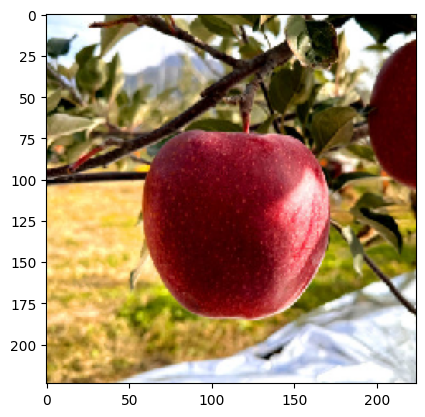

In [65]:
label = np.argmax(pred)
if label == 1:
  y = '사과'
else:
  y = '토마토'
print(y)

plt.imshow(testImage)
plt.show()